In [1]:
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from matplotlib.animation import ArtistAnimation, FuncAnimation
from tqdm import tqdm
os.chdir("../")

from datasets import CubeObstacle, CylinderObstacle
from utils.config import Hyperparameters as hparams
from utils.tools import calc_sig_strength, calc_sig_strength_gpu

np.random.seed(52)
logging.basicConfig(level=logging.INFO)

In [2]:
# Create Obstacle

obstacle_ls = [
    CubeObstacle(-30, 15, 35, 60, 20, 0.3),
    CubeObstacle(-30, -25, 45, 10, 35, 0.3),
    CylinderObstacle(0, -30, 70, 10, 0.3)
]


In [3]:
# Read datasets
df = pd.read_csv("data/data.csv")
df.head()

,gnd1_x,gnd1_y,gnd1_z,gnd2_x,gnd2_y,gnd2_z,gnd3_x,gnd3_y,gnd3_z,gnd4_x,gnd4_y,gnd4_z,result_x,result_y,result_z
0,9.998998,65.271416,0.0,4.634410,8.820827,0.0,91.410650,94.642730,0.0,-60.894203,-38.428030,0.0,14,-29,70
1,-35.555965,29.197107,0.0,-87.607635,-26.170190,0.0,48.962933,59.182583,0.0,-69.565605,70.011260,0.0,39,-47,70
2,86.555664,-23.099888,0.0,77.688286,-36.631115,0.0,-1.836605,-55.838130,0.0,47.951862,-5.184684,0.0,-29,59,70
3,21.627052,65.021220,0.0,-3.975246,-10.379313,0.0,-80.662440,-29.709475,0.0,-68.925060,-54.606280,0.0,28,-23,70
4,55.108463,-34.374540,0.0,-15.515844,63.972885,0.0,-8.228970,96.004410,0.0,-60.739185,-66.018906,0.0,34,-30,70


In [4]:
gnd_nodes = [df.iloc[0, :3].values, df.iloc[0, 3:6].values, df.iloc[0, 6:9].values, df.iloc[0, 9:12].values]
gnd_nodes = np.array(gnd_nodes, dtype=np.float32)
gnd_nodes

array([[  9.998998 ,  65.271416 ,   0.       ],
       [  4.6344104,   8.820827 ,   0.       ],
       [ 91.41065  ,  94.64273  ,   0.       ],
       [-60.894203 , -38.42803  ,   0.       ]], dtype=float32)

INFO:root:Obstacle.points.shape: (3, 2040)
INFO:root:Obstacle.points.shape: (3, 1319)
INFO:root:Obstacle.points.shape: (3, 1413)
INFO:root:gnd_nodes: [[  9.998998   65.271416    0.       ]
 [  4.6344104   8.820827    0.       ]
 [ 91.41065    94.64273     0.       ]
 [-60.894203  -38.42803     0.       ]]


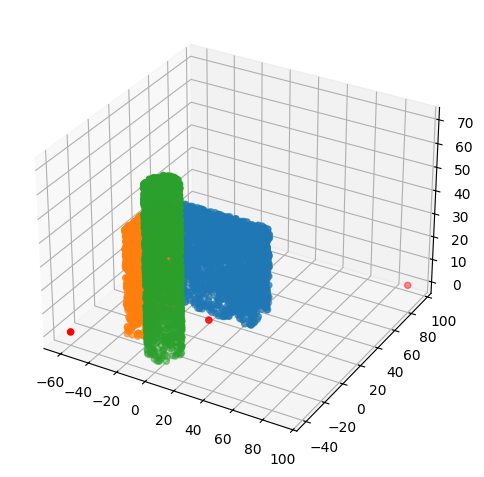

In [5]:
# environment visualization

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for obstacle in obstacle_ls:
    obstacle.plot(ax)
    logging.info(f"Obstacle.points.shape: {obstacle.points.shape}")

gnd_nodes = np.array(gnd_nodes)
logging.info(f"gnd_nodes: {gnd_nodes}")
ax.scatter(gnd_nodes[:, 0], gnd_nodes[:, 1], gnd_nodes[:, 2], c='r')
fig.tight_layout()
plt.show()

In [6]:
# Brute Force coord

X, Y = np.meshgrid(
    np.arange(-hparams.area_size // 2, hparams.area_size // 2),
    np.arange(-hparams.area_size // 2, hparams.area_size // 2),
    indexing='xy'
)
Z = np.full_like(X, 70)

station_positions = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)

In [7]:
sig = np.array([calc_sig_strength(station_pos, gnd_nodes, obstacle_ls) for station_pos in tqdm(station_positions)])
sig = sig.reshape(hparams.area_size, hparams.area_size)

max_idx = np.unravel_index(np.argmax(sig), sig.shape)
logging.info(f"Max Signal: {sig[max_idx]}, Index: {max_idx}")

100%|██████████| 40000/40000 [00:23<00:00, 1728.36it/s]
INFO:root:Max Signal: 13.1215196636628, Index: (np.int64(114), np.int64(72))


In [8]:
calc_sig_strength(np.array(df.iloc[0, 12:]), gnd_nodes, obstacle_ls)

np.float64(11.51622703758835)

INFO:root:Obstacle.points.shape: (3, 2040)
INFO:root:Obstacle.points.shape: (3, 1319)
INFO:root:Obstacle.points.shape: (3, 1413)


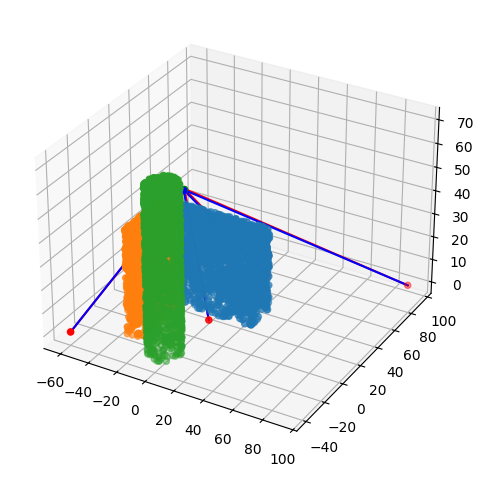

In [9]:
# Result Visualization

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for obstacle in obstacle_ls:
    obstacle.plot(ax)
    logging.info(f"Obstacle.points.shape: {obstacle.points.shape}")
    
ax.scatter(gnd_nodes[:, 0], gnd_nodes[:, 1], gnd_nodes[:, 2], c='r')
ax.scatter(max_idx[0]-(hparams.area_size//2), max_idx[1]-(hparams.area_size//2), 70, c='g')
ax.scatter(df.iloc[0, 12], df.iloc[0, 13], df.iloc[0, 14], c='b')
for gnd_node in gnd_nodes:
    ax.plot([gnd_node[0], max_idx[0]-(hparams.area_size//2)], [gnd_node[1], max_idx[1]-(hparams.area_size//2)], [gnd_node[2], 70], c='r')
    ax.plot([df.iloc[0, 12], gnd_node[0]], [df.iloc[0, 13], gnd_node[1]], [df.iloc[0, 14], gnd_node[2]], c='b')

fig.tight_layout()
plt.show()

INFO:root:Obstacle.points.shape: (3, 2040)
INFO:root:Obstacle.points.shape: (3, 1319)
INFO:root:Obstacle.points.shape: (3, 1413)
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


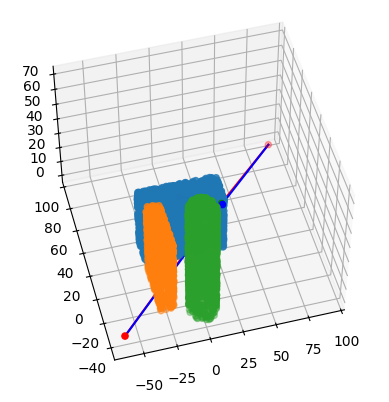

In [10]:
# save result as animation gif

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('persp')
for obstacle in obstacle_ls:
    obstacle.plot(ax)
    logging.info(f"Obstacle.points.shape: {obstacle.points.shape}")

ax.scatter(gnd_nodes[:, 0], gnd_nodes[:, 1], gnd_nodes[:, 2], c='r')
ax.scatter(max_idx[0]-(hparams.area_size//2), max_idx[1]-(hparams.area_size//2), 70, c='g')
ax.scatter(df.iloc[0, 12], df.iloc[0, 13], df.iloc[0, 14], c='b')
for gnd_node in gnd_nodes:
    ax.plot([gnd_node[0], max_idx[0]-(hparams.area_size//2)], [gnd_node[1], max_idx[1]-(hparams.area_size//2)], [gnd_node[2], 70], c='r')
    ax.plot([df.iloc[0, 12], gnd_node[0]], [df.iloc[0, 13], gnd_node[1]], [df.iloc[0, 14], gnd_node[2]], c='b')


def update(i):
    ax.view_init(elev=50, azim=255 + i)  # 시점의 높이를 높여 선이 더 잘 보이도록 설정


anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=100)

anim.save("./results/dataset_test/anim.gif", writer='imagemagick')


INFO:root:Obstacle.points.shape: (3, 2040)
INFO:root:Obstacle.points.shape: (3, 1319)
INFO:root:Obstacle.points.shape: (3, 1413)


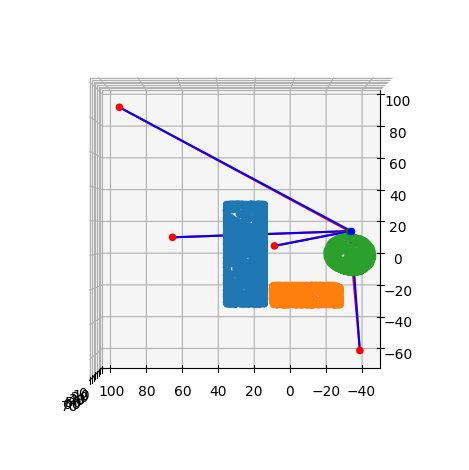

In [11]:
# Save the top view as image

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90, azim=180)
for obstacle in obstacle_ls:
    obstacle.plot(ax)
    logging.info(f"Obstacle.points.shape: {obstacle.points.shape}")

ax.scatter(gnd_nodes[:, 0], gnd_nodes[:, 1], gnd_nodes[:, 2], c='r')
ax.scatter(max_idx[0]-(hparams.area_size//2), max_idx[1]-(hparams.area_size//2), 70, c='g')
ax.scatter(df.iloc[0, 12], df.iloc[0, 13], df.iloc[0, 14], c='b')
for gnd_node in gnd_nodes:
    ax.plot([gnd_node[0], max_idx[0]-(hparams.area_size//2)], [gnd_node[1], max_idx[1]-(hparams.area_size//2)], [gnd_node[2], 70], c='r')
    ax.plot([df.iloc[0, 12], gnd_node[0]], [df.iloc[0, 13], gnd_node[1]], [df.iloc[0, 14], gnd_node[2]], c='b')

fig.tight_layout()
plt.savefig("./results/dataset_test/top.png")
plt.show()